<h1>Hamming Distance k-NN Search with FAISS</h1>

In [0]:
# import libraries
import os
import math
import faiss
import numpy as np
from keras import backend as K
from IPython.display import clear_output
from keras.models import Model, load_model

<h1>Bit Vectorize Embeddings</h1>
<p>Here we convert the embeddings into bit vectors.<br>
We do this by using the following rule:<br>
Nodes > .5 = 1<br>
Nodes <= .5 = 0
</p>

In [0]:
# bit vectorize embeddings
def bit_vectorize(x, padding):
    bit_arr = []
    for i in range(len(x)):
        b_arr = []
        for j in range(len(x[i])):
            if x[i][j] > .5:
                b_arr.append(1)
            else:
                b_arr.append(0)
        b_arr = b_arr + padding
        pb = np.packbits(b_arr)
        bit_arr.append(pb)
    rarr = np.ascontiguousarray(np.array(bit_arr))
    return rarr

<h1>Set Parameters for Search</h1>

In [0]:
# configurations
# number of embeddings to generate (change load to false in next cell)
n_test = 100000
n_train = 1000000
bitsize = 20
# set padding
p = int((math.ceil(bitsize/8.0))*8 - bitsize)
padding = []
for i in range(p):
    padding.append(0)

# similarity search
bank_size = 100000
q_size = 50000
d = bitsize + len(padding)
k = 5

<h1>Option to Load or Generate Bit Vector Data</h1>

In [0]:
load_bit_vector = True
load_test = True

# get bit vectors for database
print('Loading Bank ...')
if load_bit_vector == True:
    path = 'data/bit_vector/faiss_test/bit_vector_train' + str(bitsize) + '.npy'
    bit_vectors = np.load(path)

# option to generate and save bit vectors
else:
    # load signal data
    x_train = np.load('data/npy_data/signal_dataset/train/signals.npy')
    x_train = x_train[:n_train]
    x_train = x_train.reshape([-1, 1024, 2])
    # load model
    model = load_model('weights_best/hamm' + str(bitsize) + '_weights.hdf5')
    # get output from embedding layer
    embedding_output = Model(inputs=model.input, outputs=model.get_layer('dense_3').output)
    embeddings = embedding_output.predict(x_train)
    # bit vectorize embedding
    bit_vectors = bit_vectorize(embeddings, padding)
    np.save('data/bit_vector/faiss_test/bit_vector_train' + str(bitsize) + '.npy', bit_vectors)
print('Bank Load Complete!' + '\n')

# load snr and label data for database 
print('Loading labels and snr values ...')
labels = np.load('data/npy_data/signal_dataset/train/labels.npy')
labels = labels[:n_train]
snrs = np.load('data/npy_data/signal_dataset/train/snrs.npy')
snrs = snrs[:n_train]
print('Load complete!', '\n')


# get bit vectors for query set
print('Loading Queries ...')
if load_test == True:
    path = 'data/bit_vector/faiss_test/bit_vector_test' + str(bitsize) + '.npy'
    bit_vectors_test = np.load(path)

# option to generate and save bit vectors
else:
    # load signal data
    x_test = np.load('data/npy_data/signal_dataset/test/signals.npy')
    x_test = x_test[:n_test]
    x_test = x_test.reshape([-1, 1024, 2])
    # load model
    model = load_model('weights_best/hamm' + str(bitsize) + '_weights.hdf5')
    # get output from embedding layer
    embedding_output = Model(inputs=model.input, outputs=model.get_layer('dense_3').output)
    embeddings_test = embedding_output.predict(x_test)
    # bit vectorize embedding
    bit_vectors_test = bit_vectorize(embeddings_test, padding)
    np.save('data/bit_vector/faiss_test/bit_vector_test' + str(bitsize) + '.npy', bit_vectors_test)
print('Queries Load Complete!' + '\n')

# load snr and label data for query set
print('Loading labels and snr values ...')
test_labels = np.load('data/npy_data/signal_dataset/test/labels.npy')
test_labels = test_labels[:n_test]
test_snrs = np.load('data/npy_data/signal_dataset/test/snrs.npy')
test_snrs = test_snrs[:n_test]
print('Load complete!', '\n')


Loading Bank ...
Bank Load Complete!

Loading labels and snr values ...
Load complete! 

Loading Queries ...
Queries Load Complete!

Loading labels and snr values ...
Load complete! 



<h1>Similarity Search with FAISS<h1>

In [0]:
# initialize database
db = bit_vectors[:bank_size]
print('Size of database: ', len(db))
# initialize query set
queries = bit_vectors_test[:q_size]
print('Size of query set: ', len(queries))
print('\n')
# Initializing index.
index = faiss.IndexBinaryFlat(d)
# Adding the database vectors.
index.add(db)
print('Searching for nearest neighbors ...')
D, I = index.search(queries, k)
print('Search complete!')

Size of database:  100000
Size of query set:  50000


Searching for nearest neighbors ...
Search complete!


<h1>Get Accuracy</h1>

In [0]:
# vote function
def vote(lst):
    return max(set(lst), key=lst.count)

# get accuracy 
total = dict(zip(range(-20,31), [0]*len(range(-20,31))))
total_correct = dict(zip(range(-20,31), [0]*len(range(-20,31))))
for i in range(len(I)):
    class_idx = []
    q_snr = test_snrs[i]
    total[q_snr] = total[q_snr] + 1
    for j in range(k):
        tr_idx = I[i][j]
        class_idx.append(str(labels[tr_idx]))
    if str(test_labels[i]) == str(vote(class_idx)):
        total_correct[q_snr] = total_correct[q_snr] + 1

for i in total.keys():
    if total[i] != 0:
        accuracy = round((total_correct[i]/total[i])*100, 2)
        print("Accuracy at snr = %d and k = %d: "%(i,k), accuracy)

Accuracy at snr = 0 and k = 5:  49.2
Accuracy at snr = 2 and k = 5:  55.03
Accuracy at snr = 4 and k = 5:  65.84
Accuracy at snr = 6 and k = 5:  76.9
Accuracy at snr = 8 and k = 5:  82.75
Accuracy at snr = 10 and k = 5:  84.7
Accuracy at snr = 12 and k = 5:  86.07
Accuracy at snr = 14 and k = 5:  84.67
Accuracy at snr = 16 and k = 5:  86.65
Accuracy at snr = 18 and k = 5:  86.24
Accuracy at snr = 20 and k = 5:  85.87
Accuracy at snr = 22 and k = 5:  85.85
Accuracy at snr = 24 and k = 5:  85.87
Accuracy at snr = 26 and k = 5:  85.3
Accuracy at snr = 28 and k = 5:  85.87
Accuracy at snr = 30 and k = 5:  83.95
Accuracy at snr = -20 and k = 5:  4.6
Accuracy at snr = -18 and k = 5:  4.91
Accuracy at snr = -16 and k = 5:  4.61
Accuracy at snr = -14 and k = 5:  4.81
Accuracy at snr = -12 and k = 5:  6.13
Accuracy at snr = -10 and k = 5:  9.46
Accuracy at snr = -8 and k = 5:  15.31
Accuracy at snr = -6 and k = 5:  23.15
Accuracy at snr = -4 and k = 5:  29.18
Accuracy at snr = -2 and k = 5:  36

Text(0, 0.5, 'Accuracy')

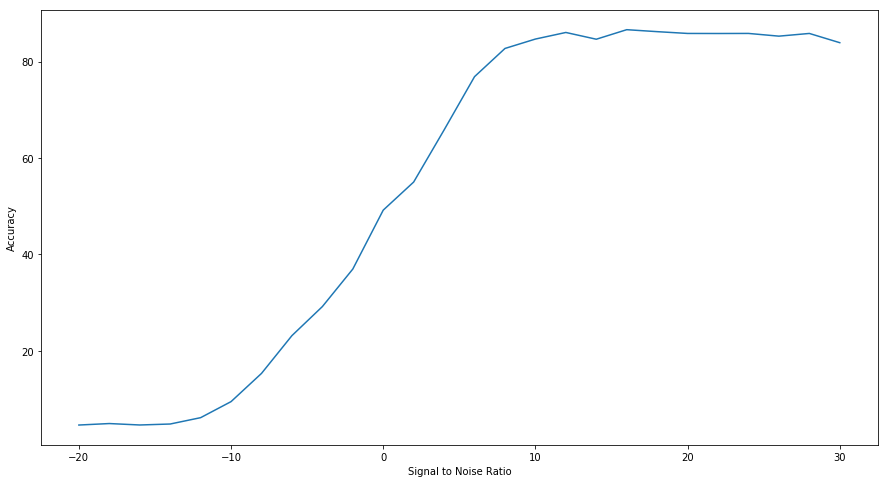

In [0]:
# plot accuracy data
x = []
y = []
keys = list(total_correct.keys())
keys = [k for k in keys if total[k] != 0]
keys.sort()
for i in keys:
    x.append(i)
    y.append((total_correct[i]/total[i])*100)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15,8))
plt.plot(x, y)
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('Accuracy')

In [0]:
# save accuracies
filename = 'data/bit_vector/snr_accuracy/hamm' + str(bitsize) + '_k' + str(k) + '.npy'
np.save(filename, y)
print('File Saved: ' + filename)

File Saved: data/bit_vector/snr_accuracy/hamm20_k5.npy
